In [1]:
## This file is different from last version NNAttempt2 in that here I willdefine all the functions used in 
#the calculation before the code starts.

## Define Functions for Data Manipulation

In [2]:
# Deviatoric stress from Cauchy stress tensor

In [2]:
import pandas as pd
import numpy as np
def deviatoric(sig):
    sig11 = sig[0,0]; sig12 = sig[0,1]; sig13 = sig[0,2]
    sig21 = sig[1,0]; sig22 = sig[1,1]; sig23 = sig[1,2]
    sig31 = sig[2,0]; sig32 = sig[2,1]; sig33 = sig[2,2]
    sigDev = np.array([[sig11,sig12,sig13],[sig21,sig22,sig23],[sig31,sig32,sig33]]) \
        - 1/3*(sig11+sig22+sig33)*np.eye(3)
    return sigDev

In [3]:
# This function reads the csv data file and converts the data into a pandas dataframe 'T' which has the 
# appropriate headers for the 12 columns for each data point.From thi T, which has both strain, stress and loading cases
# we will separate the strains, the cauchy stress matrices, the deviatoric stress matrices for each of the 918 data points

In [4]:
def readData():
    filepath = r'avgStrainStressInfoNEPureShearLoading.csv'
    columNames = ['eps11','eps22','eps33','eps12','eps13','eps23', \
        'sig11','sig22','sig33','sig12','sig13','sig23']
    opt = pd.read_csv(filepath, nrows=0)                          #fetch existing column names
    opt_names = opt.columns.tolist()
    opt_names[0:len(columNames)] = columNames
    
    # T:dataframe, Read the data file, skip the header, replace with columnNames
    T = pd.read_csv(filepath, header=None, skiprows=1, names=opt_names) 
    
    # convert columns 0 to 6 to numpy array (nominal strain) by definition = v-I. where v is the left stretch tensor
    eps_nominal_Matrix = T[columNames[0:6]].values

    #create a 2D numpy array having 918 rows and 6 columns
    sigDevMatrix = np.zeros((len(T.sig11),6))
    print(sigDevMatrix)
    sigMatrixList = []
    for k in range(len(T.sig11)):
        temp = np.array([[T.sig11[k], T.sig12[k], T.sig13[k]], \
                         [T.sig12[k], T.sig22[k], T.sig23[k]], \
                         [T.sig13[k], T.sig23[k], T.sig33[k]]])
        
        # Creates a list where each of the 198 elements is a 3 by 3 matrix.
        sigMatrixList.append(temp) # List of 918 3 x 3 matrices

        # Calculates deviatoric stress from each data point in temp
        devS = deviatoric(temp)

        # Store the deviatoric stress calculated in prev line to this List at every kth iteration.
        sigDevMatrix[k,:] = [devS[0,0],devS[1,1],devS[2,2], \
                          devS[0,1],devS[0,2],devS[1,2]]

    # Now make the cauchy stress matrix by fetching columns 6 and onwards and convert to numpy array
    sigMatrix = T[columNames[6:]].values   #numpy.ndarray = matrix = 918 x 6

    # Convert the data into batches considering the loading cases
    xrange = range(169)
    eps11= T.eps11[xrange].values; sig11=T.sig11[xrange].values
    xrange = range(169,254)
    eps22= T.eps22[xrange].values; sig22=T.sig22[xrange].values
    xrange = range(254,424)
    eps33= T.eps33[xrange].values; sig33=T.sig33[xrange].values
    xrange = range(424,594)
    eps12= T.eps12[xrange].values; sig12=T.sig12[xrange].values
    xrange = range(594,747)
    eps13= T.eps13[xrange].values; sig13=T.sig13[xrange].values      
    xrange = range(747,917)
    eps23= T.eps23[xrange].values; sig23=T.sig23[xrange].values
    
    return (T,eps_nominal_Matrix,sigDevMatrix,sigMatrix,sigMatrixList,\
            eps11,eps22,eps33,\
            eps12,eps13,eps23,\
            sig11,sig22,sig33,\
            sig12,sig13,sig23)

In [5]:
## Read data

In [6]:
(T,eps_nominal,sigDevMatrix,sigMatrix,sigMatrixList,\
            eps11,eps22,eps33,\
            eps12,eps13,eps23,\
            sig11,sig22,sig33,\
            sig12,sig13,sig23) = readData()

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [8]:
len(sigMatrixList)
sigMatrix.shape
sigMatrixList[:3]
sigMatrixList[0].shape
sigMatrix.shape
eps_nominal[5,:]
type(sigMatrix)


numpy.ndarray

In [9]:
sigMatrixList[0]

array([[ 5.881015e-02,  3.930000e-12, -1.410000e-12],
       [ 3.930000e-12,  5.032935e-03,  6.440000e-12],
       [-1.410000e-12,  6.440000e-12,  5.050588e-03]])

In [10]:
## Fiber direction matrix

In [11]:
fiber_direction = np.array([[1],[0],[0]])
#fiber_direction.shape

In [12]:
# This function estimates the deformation gradient F and the right Cauchy strain tensor C for the stress-strain 
# data. It assumes that we have the left cauchy tensor b and J  is the third invariant which is the determinant of F as inputs.

### F: Deformation gradient 
### C: Right Cauchy Tensor 
### b: Left Cauchy Tensor
$$ \bar{\mathbf{F}} = J^{-\frac{1}{3}} \mathbf{F}$$
$$ \bar{\mathbf{b}} = J^{-\frac{2}{3}} \mathbf{b} $$
$$ \bar{\mathbf{C}} = J^{-\frac{2}{3}} \mathbf{C} $$
$$ \mathbf{F} = \mathbf{R} \cdot \mathbf{U} = \mathbf{v} \cdot \mathbf{R}$$

$$ \mathbf{b} = \sum_{i=1}^{i=n}\lambda_i^2 n_i \otimes n_i$$
$$ \mathbf{U} = diag(\lambda_i)$$

In [13]:
def estimate_F_C(b,J):
    # Perform spectral decomposition of b
    eigenvalues, eigenvectors = np.linalg.eigh(b)
    
    # Since J = det(F), and for isotropic materials det(F) = det(v),
    # adjust the principal stretches to reflect volume change
    principal_stretches = np.sqrt(eigenvalues) * np.cbrt(J / np.prod(np.sqrt(eigenvalues)))

    # Reconstruct F using the principal stretches and the eigenvectors of b
    # Note: This reconstruction assumes F can be directly derived from b's eigendecomposition, 
    # which may not capture the full rotation effects in v. This is a simplification.
    U = np.diag(principal_stretches) # F = R . U , Here R is the rotation matrix and U is the right stretch tensor
    F = eigenvectors @ U @ np.linalg.inv(eigenvectors)

    # Calculate C = F.T * F
    C = np.matmul(F.T, F)
    b_estimate = np.matmul(F, F.T)  # B or b is the left cauchy green deformation tensor, symmetric
    error = np.linalg.norm(b - b_estimate)

    return F, C,error

In [14]:
import torch


In [15]:
def doubleDotProduct(A,B):
    return np.trace(np.matmul(A.T,B))

In [16]:
def deviatoric(sig):
    return sig - 1/3*np.trace(sig)*np.eye(3)

#### This class converts the inputs base into pytorch tensors. Also converts the inputs to dictionary.
#### This function is used later in the ICNN for calculating the loss

In [17]:
class bases:
    def __init__(self,base1,base2,base3,base4,base5):
        self.base1 = torch.tensor(base1,dtype=torch.float32)
        self.base2 = torch.tensor(base2,dtype=torch.float32)
        self.base3 = torch.tensor(base3,dtype=torch.float32)
        self.base4 = torch.tensor(base4,dtype=torch.float32)
        self.base5 = torch.tensor(base5,dtype=torch.float32)
    def to_dict(self):
        return {
            'base1': self.base1,
            'base2': self.base2,
            'base3': self.base3,
            'base4': self.base4,
            'base5': self.base5,
        }
    def __repr__(self) -> str:
        return f'base1: {self.base1},\n base2: {self.base2},\n base3: {self.base3},\n base4: {self.base4},\n base5: {self.base5}\n'

In [18]:
obj = bases([1,2, 3], [5, 6, 7], [1, 2, 4], [5, 6], [9, 0])
print(obj)

base1: tensor([1., 2., 3.]),
 base2: tensor([5., 6., 7.]),
 base3: tensor([1., 2., 4.]),
 base4: tensor([5., 6.]),
 base5: tensor([9., 0.])



#### This function calc_bases calculates the values of each of the terms in this sum.

$$ \begin{align}\tilde{\sigma} = \frac{2}{J} \left( \frac{\partial \Psi}{\partial \bar{I}_1} + \bar{I}_1 \frac{\partial \Psi}{\partial \bar{I}_2} \right) \text{DEV} (\bar{\mathbf{b})} \\
- \frac{2}{J} \frac{\partial \Psi}{\partial \bar{I}_2} \text{DEV}(\bar{\mathbf{b}} \cdot \bar{\mathbf{b}}) \\
+ \sum_{\alpha=1}^{N} \sum_{\beta=1}^{N} \frac{\partial \Psi}{\partial \bar{I}_{4_{\alpha \beta}}} \text{DEV}(\bar{\mathbf{a}}_{\alpha} \otimes \bar{\mathbf{a}}_{\beta} + \bar{\mathbf{a}}_{\beta} \otimes \bar{\mathbf{a}}_{\alpha}) \\
+ \sum_{\alpha=1}^{N} \sum_{\beta=1}^{N} \frac{\partial \Psi}{\partial \bar{I}_{5_{\alpha \beta}}} \text{DEV}(\bar{\mathbf{a}_{\alpha}} \otimes \bar{\mathbf{a}}_{\beta}' + \bar{\mathbf{a}}_{\alpha}' \otimes \bar{\mathbf{a}}_{\beta} + \bar{\mathbf{a}}_{\beta} \otimes \bar{\mathbf{a}}_{\alpha}' + \bar{\mathbf{a}}_{\beta}' \otimes \bar{\mathbf{a}}_{\alpha}) \end{align}
 $$
$$ \text{where } \bar{\mathbf{a}}_{\alpha} = \mathbf{\bar{F}} \cdot \mathbf{A}_{\alpha}, \quad \bar{\mathbf{a}}_{\beta}' = \bar{\mathbf{a}}_{\beta} \cdot \mathbf{\bar{b}}, \quad \text{and} \quad \bar{\mathbf{a}}_{\alpha}' = \mathbf{\bar{b}} \cdot \bar{\mathbf{a}}_{\alpha},
 $$
$$ \text{where } \bar{\mathbf{a}}_{\alpha} = \bar{\mathbf{a}}_{\beta}$$
$$ \text{where } \mathbf{\sigma}= \tilde{\mathbf{\sigma}} - p\mathbf{I} $$

$$ \bar{\mathbf{F}} = J^{-\frac{1}{3}} \mathbf{F}$$
$$ \bar{\mathbf{b}} = J^{-\frac{2}{3}} \mathbf{b} $$
$$ \bar{\mathbf{C}} = J^{-\frac{2}{3}} \mathbf{C} $$

In [19]:
def calc_bases(bbar,F,J,direction):
    dev_bbar = deviatoric(bbar)
    base1 = 2.0/J * dev_bbar
    base2 = -2.0/J * deviatoric(bbar @ bbar)
    Fbar = J**(-1/3)*F
    a_bar = Fbar @ direction
    a_bar_dash = bbar @ a_bar
    base3 = np.eye(3) 
    base4 = 2.0 * a_bar @ a_bar.T
    base5 = 2.0 * a_bar @ a_bar_dash.T + 2.0 * a_bar_dash @ a_bar.T
    return bases(base1,base2,base3,base4,base5)

In [20]:
## This function calculates the invariants of the strains and also defines the input
# of the neural network

$$ \bar{I}_1 = tr(\mathbf{\bar{b}})$$
$$ \bar{I}_2 = \frac{1}{2}({\bar{I}_1}^{2} - tr( {\mathbf{\bar{b}}}\cdot{\mathbf{\bar{b}}} ) ) $$
$$ I_3 = J^2 = \lVert \mathbf{F} \rVert^2 $$
$$ \bar{I}_{4_{\alpha \beta}} = \mathbf{A}_\alpha \cdot \mathbf{\bar{C}} \cdot \mathbf{A}_\beta $$
$$ \bar{I}_{5_{\alpha \beta}} = \mathbf{A}_\alpha \cdot \mathbf{\bar{C}}^2 \cdot \mathbf{A}_\beta$$

$$ \mathbf{\epsilon}_{{nominal}_{abaqus}} = \mathbf{v} - \mathbf{I} $$
$$ \mathbf{b} = \mathbf{v} \cdot \mathbf{v} $$
$$ \mathbf{C} = \mathbf{U} \cdot \mathbf{U} $$
$$ J = \det{\mathbf{v}} $$

In [21]:
def transforming_nominal_strain(eps_nominal):
    #Initialization
    v_mat_lin = np.zeros((len(eps_nominal),6))
    b_mat_lin = np.zeros((len(eps_nominal),6))
    I1 = np.zeros((len(eps_nominal),1))
    I2 = np.zeros((len(eps_nominal),1))
    I3 = np.zeros((len(eps_nominal),1))
    I4 = np.zeros((len(eps_nominal),1))
    I5 = np.zeros((len(eps_nominal),1))
    I1_bar = np.zeros((len(eps_nominal),1))
    I2_bar = np.zeros((len(eps_nominal),1))
    I4_bar = np.zeros((len(eps_nominal),1))
    I5_bar = np.zeros((len(eps_nominal),1))
    fiber_direction = np.array([[1],[0],[0]])
    fiber_dyad = np.matmul(fiber_direction,fiber_direction.T)
    bases_data = []
    
    for k in range(len(eps_nominal)):
        eps_nom = np.array([ [eps_nominal[k,0]  , eps_nominal[k,3], eps_nominal[k,4]], 
                    [eps_nominal[k,3], eps_nominal[k,1]  , eps_nominal[k,5]], 
                    [eps_nominal[k,4], eps_nominal[k,5], eps_nominal[k,2]  ] ])
        v_mat = eps_nom + np.eye(3)
        b_mat = np.matmul(v_mat,v_mat)
        J = np.linalg.det(v_mat)
        F, C,error = estimate_F_C(b_mat,J)
        #print(error)
        bbar = (J)**(-2/3)*b_mat
        base_obj = calc_bases(bbar,F,J,fiber_direction)
        Cbar = (J)**(-2/3)*C
        
        # Calculate invariants
        I1[k] = np.trace(b_mat)
        I2[k] = 0.5*(I1[k]**2 - np.trace(np.matmul(b_mat,b_mat)))
        I3[k] = J
        I4[k] = doubleDotProduct(C,fiber_dyad)
        I5[k] = doubleDotProduct(C @ C,fiber_dyad)
        
        
        I1_bar[k] = np.trace(bbar)
        I2_bar[k] = 0.5*(I1_bar[k]**2 - np.trace(np.matmul(bbar,bbar)))
        I4_bar[k] = doubleDotProduct(Cbar,fiber_dyad)
        I5_bar[k] = doubleDotProduct(Cbar @ Cbar,fiber_dyad)  # because alpha and beta are equal in our case
        
        bases_data.append(base_obj)    
        # e11, e22, 233, e12, e13, e23
        v_mat_lin[k,:] = [v_mat[0,0],v_mat[1,1],v_mat[2,2], \
                          v_mat[0,1],v_mat[0,2],v_mat[1,2]]
        b_mat_lin[k,:] = [b_mat[0,0],b_mat[1,1],b_mat[2,2], \
                            b_mat[0,1],b_mat[0,2],b_mat[1,2]]
    invarices = np.concatenate((I1,I2,I3,I4,I5),axis=1)       # making inputs to the neural network
    invarices_bar = np.concatenate((I1_bar,I2_bar,I3,I4_bar,I5_bar),axis=1)
    return v_mat_lin,b_mat_lin,invarices,invarices_bar,bases_data


In [22]:
v_matrix,b_mat_lin,invarices,invarices_bar,bases_data_list = transforming_nominal_strain(eps_nominal)
print(len(bases_data_list))
print(b_mat_lin.shape)
print(invarices.shape)

918
(918, 6)
(918, 5)


In [23]:
invarices

array([[3.00001541, 3.0000308 , 1.0000077 , 1.00015181, 1.00030363],
       [3.00003078, 3.0000615 , 1.00001536, 1.00030358, 1.00060724],
       [3.0000538 , 3.00010741, 1.0000268 , 1.00053126, 1.00106281],
       ...,
       [5.79367738, 5.17344634, 0.61625397, 1.        , 1.        ],
       [5.95060897, 5.31729326, 0.60554462, 1.        , 1.        ],
       [6.01787861, 5.38012282, 0.60186727, 1.        , 1.        ]])

In [24]:
bases_data_list[0]

base1: tensor([[ 2.9334e-04, -7.2001e-20,  7.8001e-20],
        [-7.2001e-20, -1.4667e-04, -3.2038e-13],
        [ 7.8001e-20, -3.2038e-13, -1.4667e-04]]),
 base2: tensor([[-5.8669e-04,  1.4401e-19, -1.5601e-19],
        [ 1.4401e-19,  2.9335e-04,  6.4072e-13],
        [-1.5601e-19,  6.4072e-13,  2.9335e-04]]),
 base3: tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 base4: tensor([[2.0003, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]]),
 base5: tensor([[ 4.0012e+00, -7.2012e-20,  7.8013e-20],
        [-7.2012e-20,  0.0000e+00,  0.0000e+00],
        [ 7.8013e-20,  0.0000e+00,  0.0000e+00]])

In [25]:
bases_data_list[0].base1


tensor([[ 2.9334e-04, -7.2001e-20,  7.8001e-20],
        [-7.2001e-20, -1.4667e-04, -3.2038e-13],
        [ 7.8001e-20, -3.2038e-13, -1.4667e-04]])

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [27]:
#converts sigMatrixList from readData() from numpy object to  torch tensor
sigMatrixList = [torch.tensor(sigMatrixList[i],dtype=torch.float32) for i in range(len(sigMatrixList))]

In [28]:
len(sigMatrixList)

918

In [29]:
sigMatrixList[0]

tensor([[ 5.8810e-02,  3.9300e-12, -1.4100e-12],
        [ 3.9300e-12,  5.0329e-03,  6.4400e-12],
        [-1.4100e-12,  6.4400e-12,  5.0506e-03]])

In [30]:
data_dict = {'invariants': invarices_bar, 'bases': bases_data_list, 'target_stress': sigMatrixList}

In [31]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        # convert invariants to tensor
        invariants = torch.tensor(data['invariants'], dtype=torch.float32)
        invariants.requires_grad = True
        self.invariants = invariants
        self.bases = data['bases']
        self.base1_list = [b.base1 for b in self.bases]
        self.base2_list = [b.base2 for b in self.bases]
        self.base3_list = [b.base3 for b in self.bases]
        self.base4_list = [b.base4 for b in self.bases]
        self.base5_list = [b.base5 for b in self.bases]
        self.base1_list = torch.stack(self.base1_list)
        self.base2_list = torch.stack(self.base2_list)
        self.base3_list = torch.stack(self.base3_list)
        self.base4_list = torch.stack(self.base4_list)
        self.base5_list = torch.stack(self.base5_list)
        # target_stress = torch.tensor(data['target_stress'], dtype=torch.float32)
        # target_stress.requires_grad = True
        target_stress = torch.stack(data['target_stress'])
        self.target_stress = target_stress
    
    def __getitem__(self, index):
        # Extract data for a single sample
        invariants = self.invariants[index,:]
        base1 = self.base1_list[index,:,:]
        base2 = self.base2_list[index,:,:]
        base3 = self.base3_list[index,:,:]
        base4 = self.base4_list[index,:,:]
        base5 = self.base5_list[index,:,:]
        bases = (base1, base2, base3, base4, base5)
        # target_stress = self.target_stress[index]
        target_stress = self.target_stress[index,:,:]
        return invariants, bases, target_stress

    def __len__(self):
        return len(self.invariants)

In [32]:
dataset = MyDataset(data_dict)
# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=128,shuffle=True)

In [33]:
from torch.utils.data import TensorDataset, DataLoader, Subset
# Split the dataset into training and validation sets
dataset_size = len(dataset)
indices = torch.randperm(dataset_size).tolist()

# Calculate split sizes
train_split = int(0.88 * dataset_size)
val_split = int(0.91 * dataset_size)  # This accounts for the next 15%

# Split indices
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create Subset instances for train, validation, and test sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [34]:
# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
dataset.base1_list[0,:,:]

tensor([[ 2.9334e-04, -7.2001e-20,  7.8001e-20],
        [-7.2001e-20, -1.4667e-04, -3.2038e-13],
        [ 7.8001e-20, -3.2038e-13, -1.4667e-04]])

## Define Neural Network Architectures

In [37]:
## Input Convex Neural Network

In [38]:
class ICNN(nn.Module):
    def __init__(self, num_layers, size_hidden,input_dim=1,output_dim=1):
        super(ICNN, self).__init__()
        self.num_layers = num_layers
        self.size_hidden = size_hidden

        # Initialize the weights for the input layer to zero
        self.w0 = nn.Parameter(torch.abs(torch.randn(input_dim, size_hidden)))
        self.b0 = nn.Parameter(torch.randn(size_hidden))
        # Weights associated with the input y should be unconstrained
        self.w_y = nn.ParameterList([
            nn.Parameter(torch.randn(input_dim, size_hidden)) 
            for _ in range(num_layers-1)
        ])
        
        # Weights associated with the previous layer's activation should be non-negative
        self.w_z = nn.ParameterList([
            nn.Parameter(torch.abs(torch.randn(size_hidden, size_hidden))) 
            for _ in range(num_layers - 1)
        ])
        
        # Biases for each layer can be any real number
        self.biases = nn.ParameterList([
            nn.Parameter(torch.randn(size_hidden)) 
            for _ in range(num_layers - 1)
        ])
        
        # Output layer weight (unconstrained)
        self.wz_out = nn.Parameter(torch.abs(torch.randn(size_hidden, output_dim)))
        self.wy_out = nn.Parameter(torch.abs(torch.randn(input_dim, output_dim)))
        self.b_out = nn.Parameter(torch.randn(output_dim))


        # Softplus activation function
        self.activation = torch.nn.functional.softplus

    def forward(self, y):
        z = self.activation(torch.matmul(y, self.w0) + self.b0)
        # Apply transformations for each layer
        for i in range(self.num_layers - 1):
            z = self.activation(torch.matmul(z, self.w_z[i]) + torch.matmul(y, self.w_y[i]) + self.biases[i])

        # Output layer
        output = self.activation(torch.matmul(z, self.wz_out) + torch.matmul(y, self.wy_out) + self.b_out)
        return output

Epoch 1: loss: 4392.9560546875
Epoch 101: loss: 69.0963363647461
Epoch 201: loss: 21.762466430664062
Epoch 301: loss: 9.585466384887695
Epoch 401: loss: 5.008385181427002
Epoch 501: loss: 2.9683785438537598
Epoch 601: loss: 1.915298342704773
Epoch 701: loss: 1.3213387727737427
Epoch 801: loss: 0.9624996781349182
Epoch 901: loss: 0.7334870100021362
Epoch 1001: loss: 0.5807313919067383
Epoch 1101: loss: 0.5016278028488159
Epoch 1201: loss: 0.456654816865921
Epoch 1301: loss: 0.4244683086872101
Epoch 1401: loss: 0.3959487974643707
Epoch 1501: loss: 0.3712952435016632
Epoch 1601: loss: 0.3494914174079895
Epoch 1701: loss: 0.33003944158554077
Epoch 1801: loss: 0.31267523765563965
Epoch 1901: loss: 0.2971600294113159
Epoch 2001: loss: 0.2832798957824707
Epoch 2101: loss: 0.2708442807197571
Epoch 2201: loss: 0.2596842348575592
Epoch 2301: loss: 0.2496504932641983
Epoch 2401: loss: 0.2406112104654312
Epoch 2501: loss: 0.23244991898536682
Epoch 2601: loss: 0.2250639945268631
Epoch 2701: loss: 0

Text(0, 0.5, 'Loss')

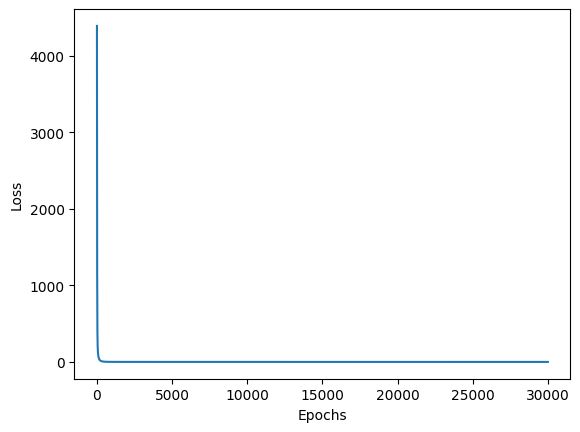

In [40]:
import matplotlib.pyplot as plt
convex_model = ICNN(num_layers= 3, size_hidden = 5, input_dim=1,output_dim=1)
x = torch.linspace(0,1,100,dtype=torch.float32).reshape(-1,1)
# ylabel = torch.sin(2*np.pi*x)
ylabel = x*x
x.requires_grad = True
criteron = nn.MSELoss()
optimizer = torch.optim.Adam(convex_model.parameters(), lr=0.01)
loss_list = []
for epoch in range(30000):
    optimizer.zero_grad()
    yp = convex_model(x)#prediction, forward step
    loss = criteron(yp,ylabel)
    loss.backward()#gradients
    optimizer.step()#update parameters
    with torch.no_grad(): # icnn condition
        for w_z in convex_model.w_z:
            w_z.data.clamp_(min=0)
        convex_model.wz_out.data.clamp_(min=0)
    loss_list.append(loss.item())
    if epoch%100 == 0:
        print(f'Epoch {epoch+1}: loss: {loss.item()}')
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [24]:
import torch
import torch.nn as nn

class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden_layers):
        super(FeedforwardNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        
        # Define the input layer
        self.input_layer = nn.Linear(self.input_size, self.hidden_size)
        
        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(self.num_hidden_layers):
            self.hidden_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        
        # Define the output layer
        self.output_layer = nn.Linear(self.hidden_size, self.output_size)
        
        # Define the activation function
        # self.activation = nn.Tanh()
        self.activation = nn.functional.softplus
        
    def forward(self, x):
        # Pass the input through the input layer and activation function
        x = self.activation(self.input_layer(x))
        
        # Pass the input through each hidden layer and activation function
        for i in range(self.num_hidden_layers):
            x = self.activation(self.hidden_layers[i](x))
        
        # Pass the input through the output layer
        x = self.activation(self.output_layer(x))
        
        return x


$$ \begin{align}\tilde{\sigma} = \frac{2}{J} \left( \frac{\partial \Psi}{\partial \bar{I}_1} + \bar{I}_1 \frac{\partial \Psi}{\partial \bar{I}_2} \right) \text{DEV} (\bar{\mathbf{b})} \\
- \frac{2}{J} \frac{\partial \Psi}{\partial \bar{I}_2} \text{DEV}(\bar{\mathbf{b}} \cdot \bar{\mathbf{b}}) \\
+ \sum_{\alpha=1}^{N} \sum_{\beta=1}^{N} \frac{\partial \Psi}{\partial \bar{I}_{4_{\alpha \beta}}} \text{DEV}(\bar{\mathbf{a}}_{\alpha} \otimes \bar{\mathbf{a}}_{\beta} + \bar{\mathbf{a}}_{\beta} \otimes \bar{\mathbf{a}}_{\alpha}) \\
+ \sum_{\alpha=1}^{N} \sum_{\beta=1}^{N} \frac{\partial \Psi}{\partial \bar{I}_{5_{\alpha \beta}}} \text{DEV}(\bar{\mathbf{a}_{\alpha}} \otimes \bar{\mathbf{a}}_{\beta}' + \bar{\mathbf{a}}_{\alpha}' \otimes \bar{\mathbf{a}}_{\beta} + \bar{\mathbf{a}}_{\beta} \otimes \bar{\mathbf{a}}_{\alpha}' + \bar{\mathbf{a}}_{\beta}' \otimes \bar{\mathbf{a}}_{\alpha}) \end{align}
 $$
$$ \text{where } \bar{\mathbf{a}}_{\alpha} = \mathbf{\bar{F}} \cdot \mathbf{A}_{\alpha}, \quad \bar{\mathbf{a}}_{\beta}' = \bar{\mathbf{a}}_{\beta} \cdot \mathbf{\bar{b}}, \quad \text{and} \quad \bar{\mathbf{a}}_{\alpha}' = \mathbf{\bar{b}} \cdot \bar{\mathbf{a}}_{\alpha},
 $$
$$ \text{where } \bar{\mathbf{a}}_{\alpha} = \bar{\mathbf{a}}_{\beta}$$
$$ \text{where } \mathbf{\sigma}= \tilde{\mathbf{\sigma}} - p\mathbf{I} $$

In [56]:
print(torch.tensor([1,2,7,8]).unsqueeze(1).unsqueeze(2).expand(-1, 3, 3).shape)

torch.Size([4, 3, 3])


In [51]:
def cauchy_stress_vectorized(X,dPsidX,base1,base2,base3,base4,base5):
    # X = I1_bar, I2_bar, J, I4_bar, I5_bar
    dPsidI1bar = dPsidX[:,0]
    dPsidI2bar = dPsidX[:,1]
    dPsidJ = dPsidX[:,2]
    dPsidI4bar = dPsidX[:,3]
    dPsidI5bar = dPsidX[:,4]
    I1bar = X[:,0]
    dPsidI1bar_expanded = dPsidI1bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI2bar_expanded = dPsidI2bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidJ_expanded = dPsidJ.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI4bar_expanded = dPsidI4bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    dPsidI5bar_expanded = dPsidI5bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    I1bar_expanded = I1bar.unsqueeze(1).unsqueeze(2).expand(-1, 3, 3)
    # sig size = (batch_size, 3, 3)
    sig = (dPsidI1bar_expanded + I1bar_expanded * dPsidI2bar_expanded) * base1 + \
            + dPsidI2bar_expanded * base2 +  \
            + dPsidJ_expanded * base3 + \
            + dPsidI4bar_expanded * base4 + \
            + dPsidI5bar_expanded * base5
    return sig



Epoch [100/10000], Loss: 190984633534860566200320.0000
Epoch [200/10000], Loss: 215036222186623198035968.0000
Epoch [300/10000], Loss: 204736085640760317181952.0000
Epoch [400/10000], Loss: 226673346857463185408000.0000
Epoch [500/10000], Loss: 177234275240720312827904.0000
Epoch [600/10000], Loss: 196945768012534087942144.0000
Epoch [700/10000], Loss: 180792406613769202958336.0000
Epoch [800/10000], Loss: 178124547378008865898496.0000
Epoch [900/10000], Loss: 185443216528059465203712.0000
Epoch [1000/10000], Loss: 191990243421556031094784.0000
Epoch [1100/10000], Loss: 179283939429380337434624.0000
Epoch [1200/10000], Loss: 198538834190023201390592.0000
Epoch [1300/10000], Loss: 178706808766632342585344.0000
Epoch [1400/10000], Loss: 201190139319453231349760.0000
Epoch [1500/10000], Loss: 180832552826747490402304.0000
Epoch [1600/10000], Loss: 241239541794250812293120.0000
Epoch [1700/10000], Loss: 194802319176383839862784.0000
Epoch [1800/10000], Loss: 175850688933348757209088.0000
E

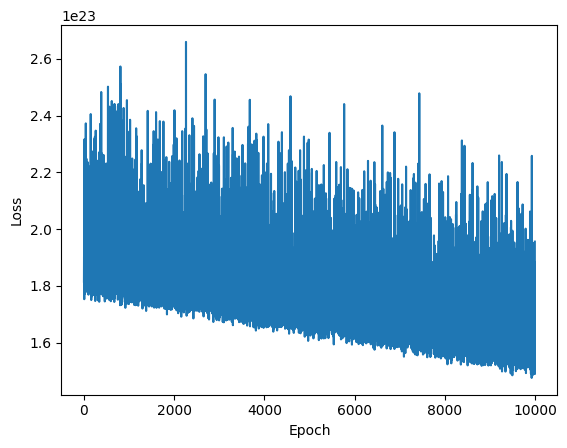

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim





def train(model, train_loader, optimizer, criterion, print_every=100):
    model.train()
    losses = []
    best_loss = 1000000
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (invariants, bases, target_stress) in enumerate(train_loader):
            base1,base2,base3,base4,base5 = bases
            optimizer.zero_grad()
            psi = model(invariants)
            dPsidX = torch.autograd.grad(psi, invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
            sigma = cauchy_stress_vectorized(invariants,dPsidX,base1,base2,base3,base4,base5)
            loss = criterion(sigma, target_stress)
            loss.backward()
            optimizer.step()
            # ICNN condition
            with torch.no_grad():
                for w_z in model.w_z:
                    w_z.data.clamp_(min=0)
                model.wz_out.data.clamp_(min=0)
            
            running_loss += loss.item()
            
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model_icnn.pth')
        if (epoch + 1) % print_every == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs , running_loss))
            # save current model
            torch.save(model.state_dict(), 'current_model_icnn.pth')
                
        losses.append(running_loss)
    return losses

# Example usage
input_size = 5
output_size = 1
hidden_size = 9
num_hidden_layers = 12
num_epochs = 10000


# model = FeedforwardNN(input_size, output_size, hidden_size, num_hidden_layers)
model = ICNN(num_layers=num_hidden_layers, 
             size_hidden=hidden_size, 
             input_dim=input_size, 
             output_dim=output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

losses = train(model, dataloader, optimizer, criterion, print_every=100)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [29]:
def train_feed(model, train_loader, optimizer, criterion, print_every=100):
    model.train()
    losses = []
    best_loss = 1000000
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (invariants, bases, target_stress) in enumerate(train_loader):
            base1,base2,base3,base4,base5 = bases
            optimizer.zero_grad()
            psi = model(invariants)
            dPsidX = torch.autograd.grad(psi, invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
            sigma = cauchy_stress_vectorized(invariants,dPsidX,base1,base2,base3,base4,base5)
            loss = criterion(sigma, target_stress)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model_feed.pth')
        if (epoch + 1) % print_every == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs , running_loss))
            # save current model
            torch.save(model.state_dict(), 'current_model_feed.pth')
                
        losses.append(running_loss)
    return losses


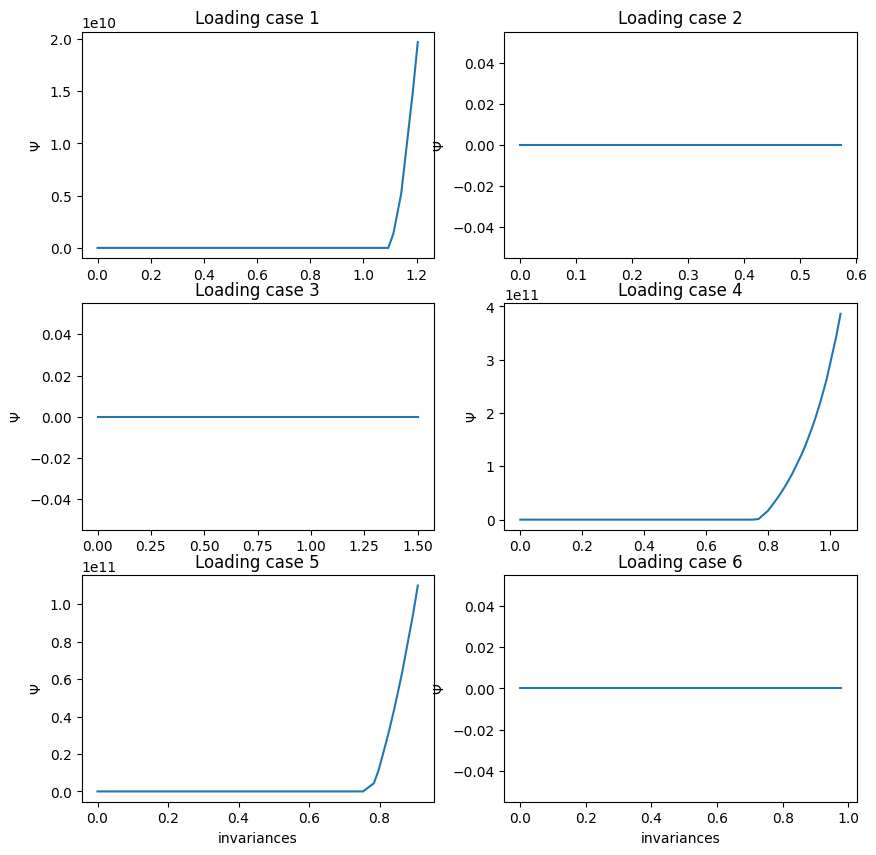

In [51]:
class Visualization:
    def __init__(self, data):
        # convert invariants to tensor
        invariants = torch.tensor(data['invariants'], dtype=torch.float32)
        invariants.requires_grad = True
        self.invariants = invariants
        self.bases = data['bases']
        self.base1_list = [b.base1 for b in self.bases]
        self.base2_list = [b.base2 for b in self.bases]
        self.base3_list = [b.base3 for b in self.bases]
        self.base4_list = [b.base4 for b in self.bases]
        self.base5_list = [b.base5 for b in self.bases]
        self.base1_list = torch.stack(self.base1_list)
        self.base2_list = torch.stack(self.base2_list)
        self.base3_list = torch.stack(self.base3_list)
        self.base4_list = torch.stack(self.base4_list)
        self.base5_list = torch.stack(self.base5_list)
        target_stress = torch.stack(data['target_stress'])
        self.target_stress = target_stress
        self.end_ranges = [170,255,425,595,748,918]
    def forward(self,model):
        psi = model(self.invariants)
        dPsidX = torch.autograd.grad(psi, self.invariants, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        sigma = cauchy_stress_vectorized(self.invariants,dPsidX,self.base1_list,self.base2_list,self.base3_list,self.base4_list,self.base5_list)
        return sigma
    def get_psi(self,model,epsMatrix=eps_nominal):
        with torch.no_grad():
            psi = model(self.invariants)
        start_range = 0
        # Set plot parameters
        fontsize = 14
        figsize = (10, 10)  # Set figure size
        # Initialize plot with specified figure size
        plt.figure(figsize=figsize)
        for i,end_range in enumerate(self.end_ranges):
            x = epsMatrix[start_range:end_range,i]
            psi_sub = psi[start_range:end_range].detach().numpy()
            start_range = end_range
            plt.subplot(3, 2, i + 1)
            plt.plot(x,psi_sub)
            plt.title(f'Loading case {i+1}')
            if i>3:
                plt.xlabel('invariances')
            plt.ylabel('$\Psi$')
    def get_sigma_lin(self,model):
        sigma = self.forward(model).detach().numpy()
        sigma_labeled = self.target_stress.detach().numpy()
        sigma_pred_lin = np.zeros((sigma.shape[0],6))
        sigma_labeled_lin = np.zeros((sigma.shape[0],6))
        for i in range(sigma.shape[0]):
            sigma_pred_lin[i,:] = [sigma[i,0,0],sigma[i,1,1],sigma[i,2,2],sigma[i,0,1],sigma[i,0,2],sigma[i,1,2]]
            sigma_labeled_lin[i,:] = [sigma_labeled[i,0,0],sigma_labeled[i,1,1],sigma_labeled[i,2,2],sigma_labeled[i,0,1],sigma_labeled[i,0,2],sigma_labeled[i,1,2]]
        return sigma_pred_lin,sigma_labeled_lin
visualizer = Visualization(data_dict)
sigma_pred_lin,sigma_labeled_lin = visualizer.get_sigma_lin(model)
visualizer.get_psi(model)


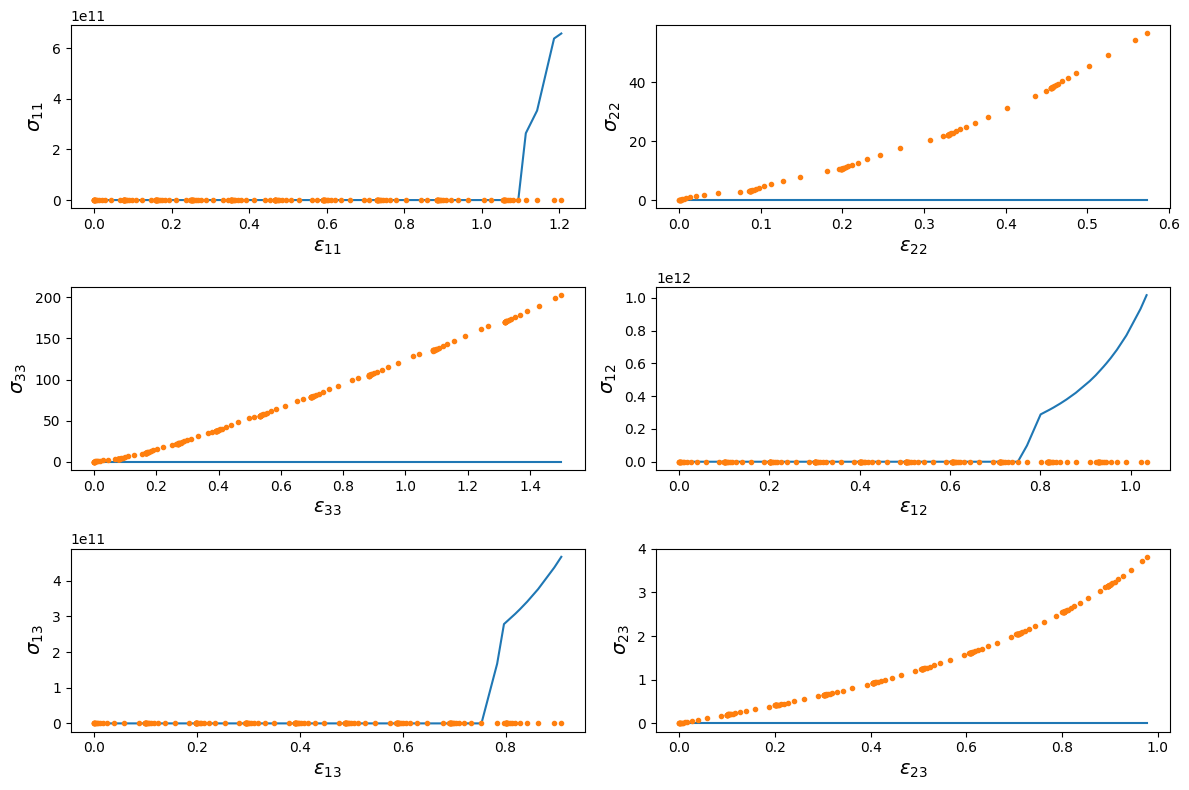

In [40]:
def plotResults(model, epsMatrix=eps_nominal):
    # Retrieve predicted stress and experimental stress data
    sig_list_pred, stressList_exp = visualizer.get_sigma_lin(model)
    
    # Set plot parameters
    fontsize = 14
    figsize = (12, 8)  # Set figure size
    
    # Initialize plot with specified figure size
    plt.figure(figsize=figsize)
    
    # Define initial range and subplot positions
    ylimit = 170
    start_range = 0
    end_range = ylimit
    subplot_positions = [(i, j) for i in range(1, 4) for j in range(1, 3)]
    indices = [11,22,33,12,13,23]
    # Iterate over components to plot each on a different subplot
    for component, position in zip(range(6), subplot_positions):
        plt.subplot(3, 2, component + 1)
        
        # Adjust ranges for each component
        if component > 0:
            start_range = end_range + 1
            if component == 1:
                end_range = 255
            elif component == 2:
                end_range = 425
            elif component == 3:
                end_range = 595
            elif component == 4:
                end_range = 748
            elif component == 5:
                end_range = 918
        
        # Extract data for current component
        eps = epsMatrix[start_range:end_range, component]
        sig = sig_list_pred[start_range:end_range, component]
        sig_exp = stressList_exp[start_range:end_range, component]
        
        # Plot model prediction and experimental data
        plt.plot(eps, sig, label='Model Prediction')
        plt.plot(eps, sig_exp, '.', label='Experimental Data')
        
        # Set axis labels with dynamic component labels
        plt.xlabel(f'$\epsilon_{{{indices[component]}}}$', fontsize=fontsize)
        plt.ylabel(f'$\sigma_{{{indices[component]}}}$', fontsize=fontsize)
        
        # Optionally, add legend or other customizations here
        # plt.legend()
    
    plt.tight_layout()  # Adjust layout to not overlap subplots
plotResults(model)

In [28]:
num_epochs = 1000000
losses = train(model, dataloader, optimizer, criterion)
plt.plot(losses)
plt.xlabel('Epoch')


plt.ylabel('Loss')


Epoch [100/1000000], Loss: 150229529383353003802624.0000
Epoch [200/1000000], Loss: 164985585947331409215488.0000
Epoch [300/1000000], Loss: 144917462691175372685312.0000
Epoch [400/1000000], Loss: 132822839852188953477120.0000
Epoch [500/1000000], Loss: 142262511897846986309632.0000
Epoch [600/1000000], Loss: 138836363578427769356288.0000
Epoch [700/1000000], Loss: 137467861515058137792512.0000
Epoch [800/1000000], Loss: 133441867502270376050688.0000
Epoch [900/1000000], Loss: 152642899211369888874496.0000
Epoch [1000/1000000], Loss: 143462337266672990158848.0000
Epoch [1100/1000000], Loss: 134285541457164480020480.0000
Epoch [1200/1000000], Loss: 156799453703255028137984.0000
Epoch [1300/1000000], Loss: 146007287639102852169728.0000
Epoch [1400/1000000], Loss: 138702863937623579164672.0000
Epoch [1500/1000000], Loss: 132318971496379208171520.0000
Epoch [1600/1000000], Loss: 130357518750670536048640.0000
Epoch [1700/1000000], Loss: 132991190035759596830720.0000
Epoch [1800/1000000], L

KeyboardInterrupt: 

Epoch [100/10000], Loss: 31949.4971
Epoch [200/10000], Loss: 35778.6985
Epoch [300/10000], Loss: 31882.7488
Epoch [400/10000], Loss: 27596.9680
Epoch [500/10000], Loss: 24084.5547
Epoch [600/10000], Loss: 19514.0496
Epoch [700/10000], Loss: 14544.5756
Epoch [800/10000], Loss: 11913.6981
Epoch [900/10000], Loss: 9642.1546
Epoch [1000/10000], Loss: 7881.2324
Epoch [1100/10000], Loss: 7453.0647
Epoch [1200/10000], Loss: 6639.1920
Epoch [1300/10000], Loss: 6243.6807
Epoch [1400/10000], Loss: 5644.9698
Epoch [1500/10000], Loss: 5426.4047
Epoch [1600/10000], Loss: 5054.1575
Epoch [1700/10000], Loss: 4522.9777
Epoch [1800/10000], Loss: 4343.9014
Epoch [1900/10000], Loss: 4376.5240
Epoch [2000/10000], Loss: 3851.6450
Epoch [2100/10000], Loss: 4256.7009
Epoch [2200/10000], Loss: 3867.1973
Epoch [2300/10000], Loss: 3721.3052
Epoch [2400/10000], Loss: 3709.8427
Epoch [2500/10000], Loss: 3898.6114
Epoch [2600/10000], Loss: 3991.5727
Epoch [2700/10000], Loss: 4043.5538
Epoch [2800/10000], Loss: 360

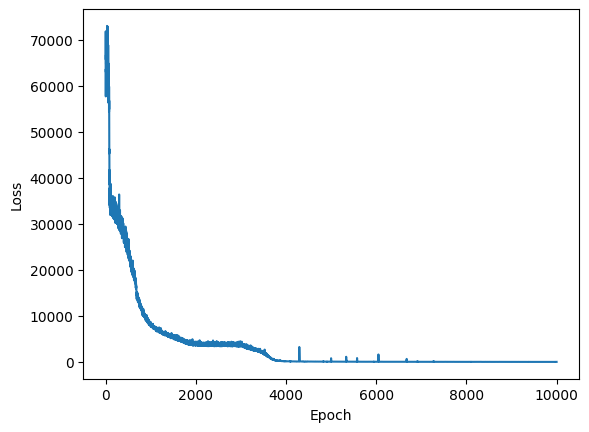

In [30]:
# Example usage
input_size = 5
output_size = 1
hidden_size = 9
num_hidden_layers = 12
num_epochs = 10000


model_fnn = FeedforwardNN(input_size, output_size, hidden_size, num_hidden_layers)

optimizer = optim.Adam(model_fnn.parameters(), lr=0.0001)
criterion = nn.MSELoss()

losses = train_feed(model_fnn, dataloader, optimizer, criterion, print_every=100)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

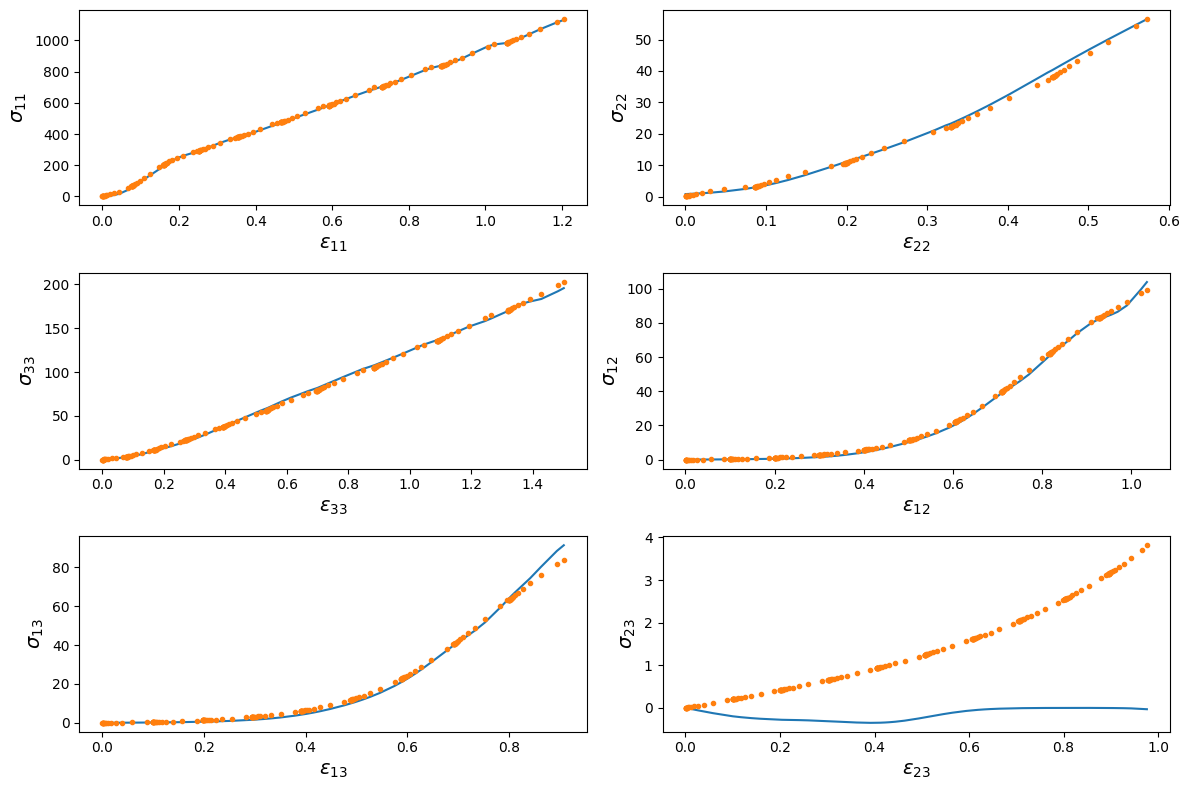

In [41]:
plotResults(model_fnn)

Epoch [100/2000], Loss: 38.5541
Epoch [200/2000], Loss: 42.6820
Epoch [300/2000], Loss: 38.7357
Epoch [400/2000], Loss: 39.5928
Epoch [500/2000], Loss: 44.1654
Epoch [600/2000], Loss: 39.6984
Epoch [700/2000], Loss: 38.0114
Epoch [800/2000], Loss: 40.2038
Epoch [900/2000], Loss: 38.9685
Epoch [1000/2000], Loss: 44.1404
Epoch [1100/2000], Loss: 36.5471
Epoch [1200/2000], Loss: 36.9486
Epoch [1300/2000], Loss: 37.3732
Epoch [1400/2000], Loss: 37.7302
Epoch [1500/2000], Loss: 40.3569
Epoch [1600/2000], Loss: 38.9036
Epoch [1700/2000], Loss: 35.5067
Epoch [1800/2000], Loss: 35.9013
Epoch [1900/2000], Loss: 38.3775
Epoch [2000/2000], Loss: 34.8621


Text(0, 0.5, 'Loss')

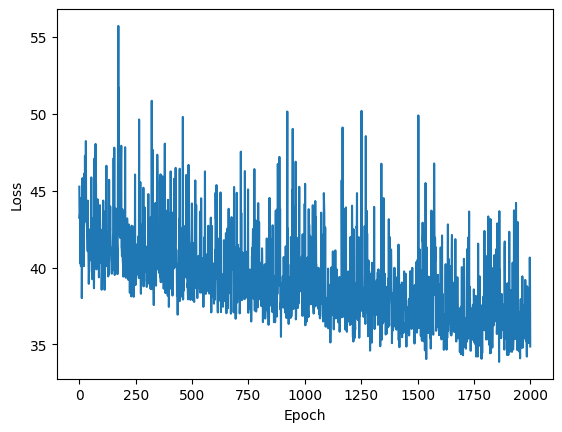

In [44]:
num_epochs = 2000
losses = train_feed(model_fnn, dataloader, optimizer, criterion)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

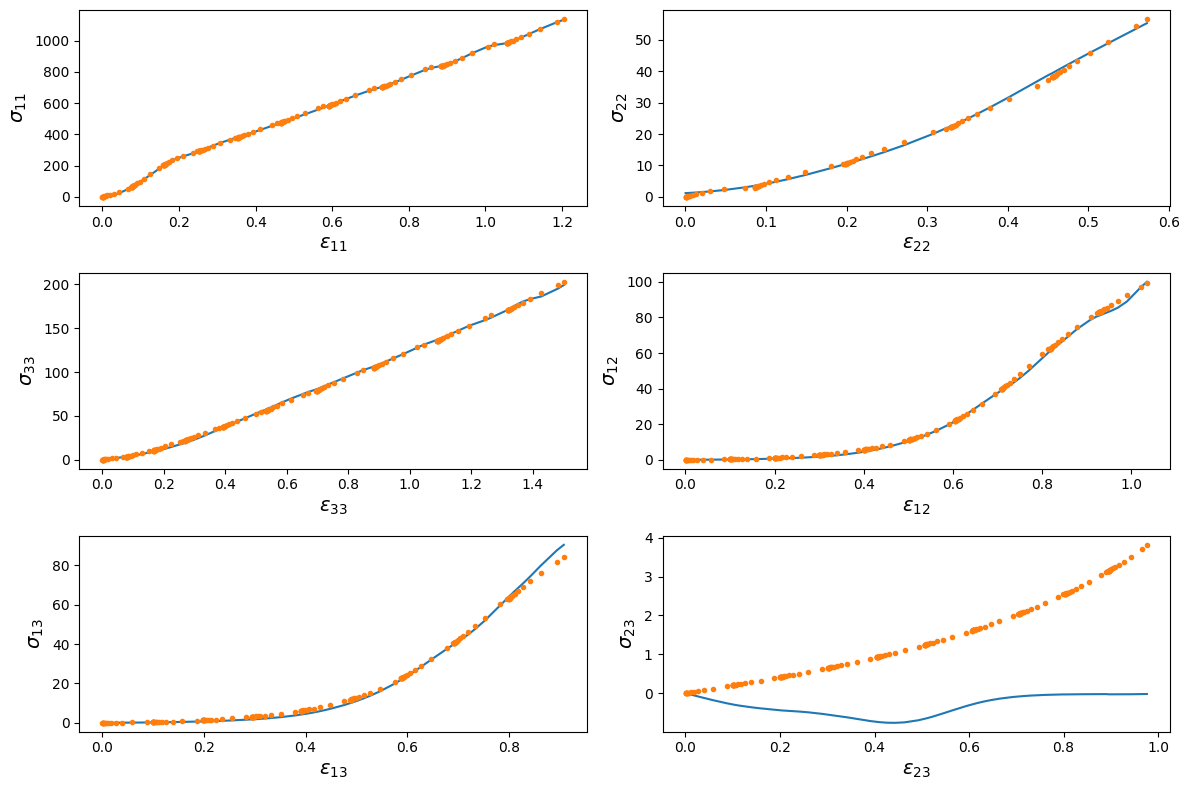

In [45]:
plotResults(model_fnn)

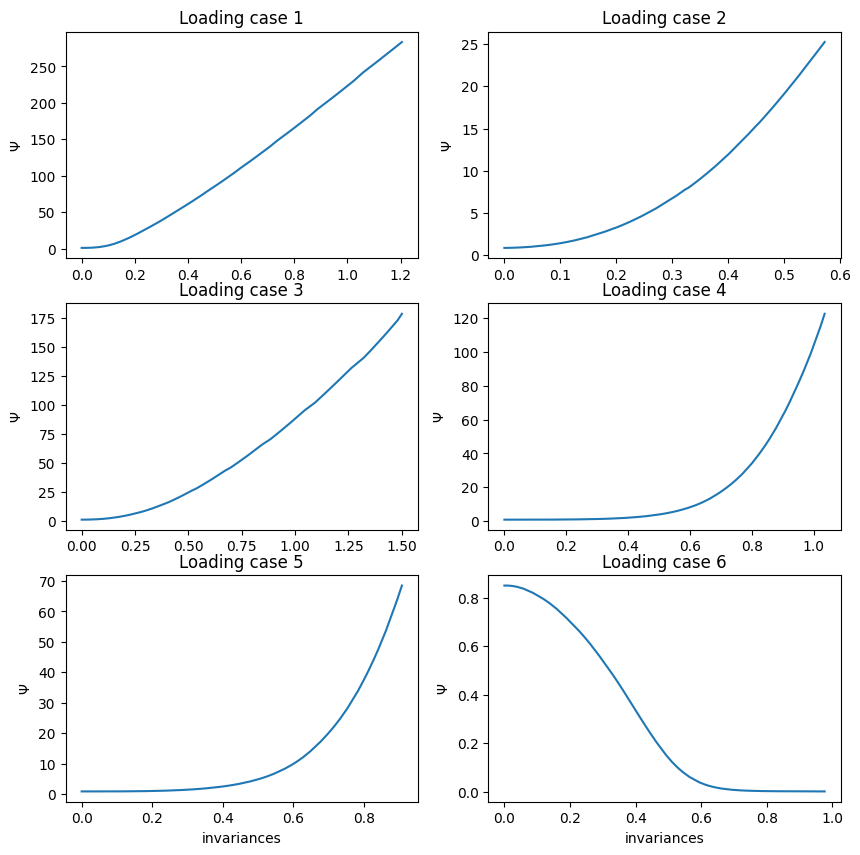

In [52]:
visualizer.get_psi(model_fnn)

Epoch [100/20000], Loss: 35.4560
Epoch [200/20000], Loss: 33.9402
Epoch [300/20000], Loss: 35.4819
Epoch [400/20000], Loss: 34.5566
Epoch [500/20000], Loss: 36.7486
Epoch [600/20000], Loss: 34.3538
Epoch [700/20000], Loss: 36.8878
Epoch [800/20000], Loss: 35.9816
Epoch [900/20000], Loss: 35.3657
Epoch [1000/20000], Loss: 35.6544
Epoch [1100/20000], Loss: 33.9838
Epoch [1200/20000], Loss: 33.2280
Epoch [1300/20000], Loss: 35.7141
Epoch [1400/20000], Loss: 42.5566
Epoch [1500/20000], Loss: 32.3053
Epoch [1600/20000], Loss: 32.6926
Epoch [1700/20000], Loss: 31.8207
Epoch [1800/20000], Loss: 34.8054
Epoch [1900/20000], Loss: 34.9384
Epoch [2000/20000], Loss: 33.4759
Epoch [2100/20000], Loss: 32.1479
Epoch [2200/20000], Loss: 35.7275
Epoch [2300/20000], Loss: 31.9976
Epoch [2400/20000], Loss: 35.9678
Epoch [2500/20000], Loss: 30.2521
Epoch [2600/20000], Loss: 34.7454
Epoch [2700/20000], Loss: 35.9139
Epoch [2800/20000], Loss: 31.4931
Epoch [2900/20000], Loss: 34.6873
Epoch [3000/20000], Los

Text(0, 0.5, 'Loss')

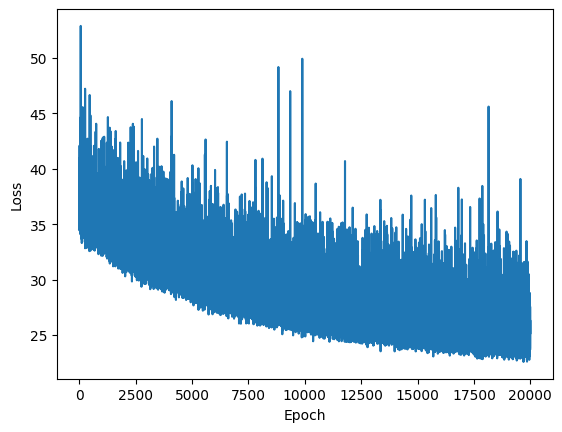

In [53]:
num_epochs = 20000
losses = train_feed(model_fnn, dataloader, optimizer, criterion)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

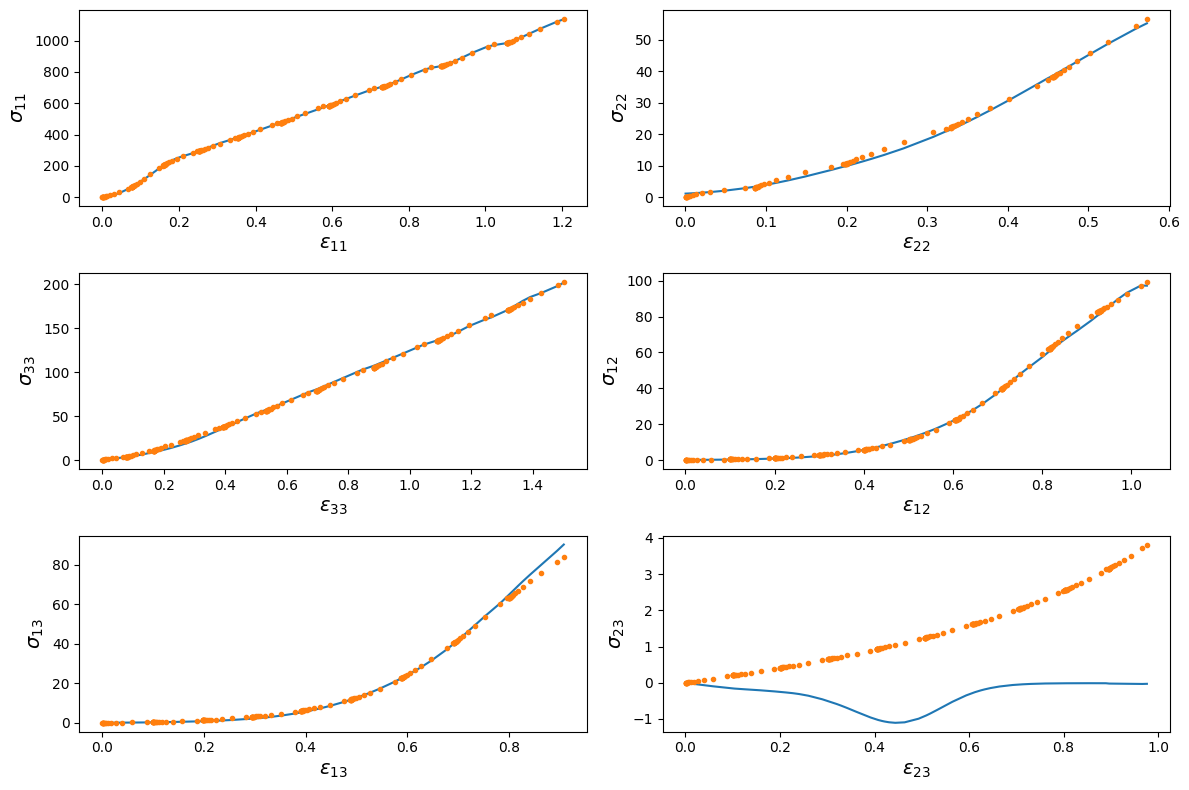

In [54]:
plotResults(model_fnn)

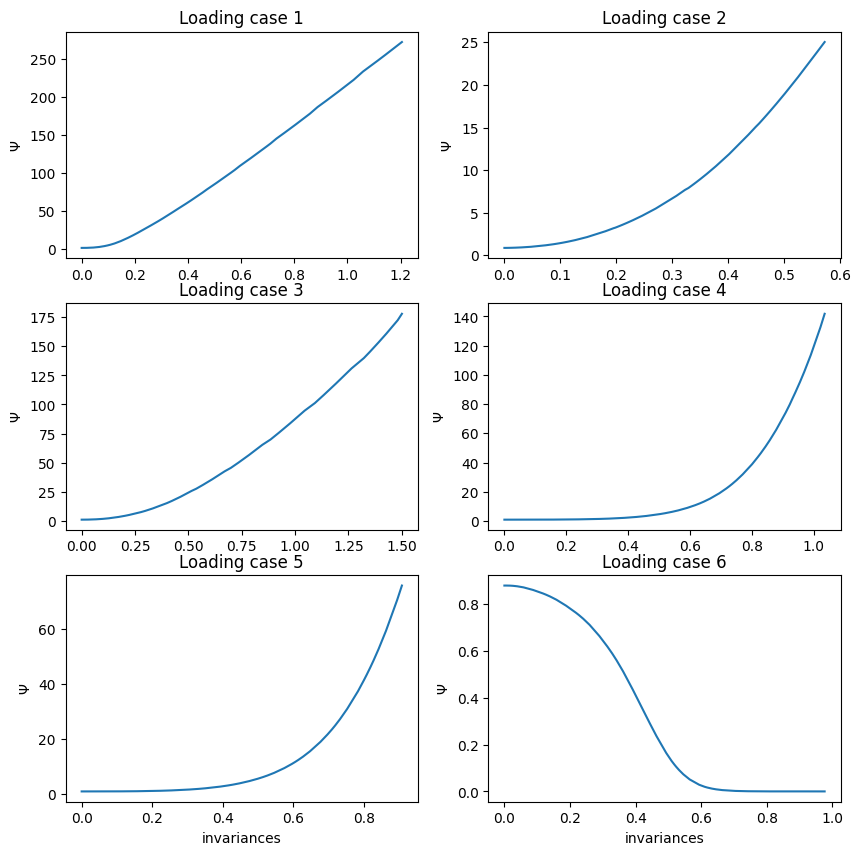

In [55]:
visualizer.get_psi(model_fnn)